In [2]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from itertools import product
from dataclasses import dataclass
import os
import math
import sys
from typing import Dict, Any, List, Optional
sys.path.append('../../../../')

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter

from multitask_nlp.utils.plotting import Task, get_overall_score, visualize_boxplot, plot_gain_matrix

color_pallette = 'muted'
sns.set_theme(style='whitegrid', context='talk', palette=color_pallette, 
              rc={'font.family': 'serif', 'font.serif': 'Times New Roman', 'mathtext.fontset': 'dejavuserif'})

tasks = [
    Task(name='Multiemo', measure='macro_f1_sentiment', 
         measure_name='Macro F1', size=6572),
    Task(name='AllegroReviews', measure='w_mae_score_rating', 
         measure_name=r'$1-wMAE$', size=8180),
    Task(name='CBD', measure='macro_f1_target', 
         measure_name='Macro F1', size=8041),
    Task(name='CDSC-E', measure='accuracy_entailment_judgment', 
         measure_name='Macro F1', size=7000),
    Task(name='CDSC-R', measure='r2_relatedness_score', 
         measure_name='R2', size=7000),
    Task(name='DYK', measure='macro_f1_target', 
         measure_name='Macro F1', size=4103),
    Task(name='NKJP_NER', measure='accuracy_target', 
         measure_name='Macro F1', size=13794),
    Task(name='PSC', measure='macro_f1_label', 
         measure_name='Macro F1', size=3302)
]

cols_to_display = ['dataset', 'learning_kind', 'model_name', 'model_type',
       'mt_dataset_type',  'scale_class_loss', 'uncertainty_loss', 'type', 'overall_score', 'weighted_overall_score']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def get_type(row):
    ttype = row['learning_kind']
    if not pd.isna(row['mt_dataset_type']):
        ttype += '_' + str(row['mt_dataset_type'])
        if row['mt_dataset_type'] == 'proportional_sampling':
            ttype += r'_$\alpha={}$'.format(row['alpha'])
        
    return ttype

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['uncertainty_loss'] = df['uncertainty_loss'].fillna(False)
    df['type'] = df.apply(lambda x: get_type(x), axis=1)
    df['overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks), axis=1)
    df['weighted_overall_score'] = df.apply(lambda x: get_overall_score(x, tasks=tasks, weighted=True), axis=1)
    
    considered_learning_kind = ['STL', 'MTL Finetuning']
    considered_types = []
    for kind in considered_learning_kind:
        considered_types += [t for t in df['type'].unique() if t.startswith(kind)]
    
    for learning_kind, learning_type, scale_class_loss, uncertainty_loss, model_name in product(
            considered_learning_kind, considered_types, df['scale_class_loss'].unique(),
            df['uncertainty_loss'].unique(), df['model_name'].unique()
    ):
        curr_df = df[(df['learning_kind'] == learning_kind) & 
                     (df['type'] == learning_type) & 
                     (df['scale_class_loss'] == scale_class_loss) &
                     (df['uncertainty_loss'] == uncertainty_loss) &
                     (df['model_name'] == model_name)]

        if len(curr_df) > 0:   
            results = {}
            for task_name in curr_df.dataset.unique():
                for task in tasks:
                    if task_name == task.name:
                        col_measure = f'{task.name}_test_{task.measure}'
                        results[task.name] = curr_df[curr_df.dataset == task.name][col_measure].values, task.size

            total_size = sum([task.size for task in tasks])
            overall_results = sum([v[0] for v in results.values()]) / len(tasks)
            weighted_overall_results = sum([v[1]*v[0] for v in results.values()]) / total_size

            records = [
                {'learning_kind': learning_kind,
                 'type': learning_type, 
                 'scale_class_loss': scale_class_loss, 
                 'uncertainty_loss': uncertainty_loss,
                 'model_name': model_name,
                 'overall_score': r1, 
                 'weighted_overall_score': r2}
                for r1, r2 in zip(overall_results, weighted_overall_results)
            ]
            df = pd.concat([df, pd.DataFrame(records)], ignore_index=True) 

    return df

In [5]:
def get_model_kind(r):
    kind = r['model_name']
    if r['scale_class_loss'] not in (None, 'none'):
        kind += ' ' + r['scale_class_loss']
    if r['uncertainty_loss'] is True:
        kind += ' UW'
        
    return kind

def format_score(x):
    if x == 0:
        return '00.00'
    else:
        return f'{round(100*x, 2):.2f}'

# Eksperymenty z Fine-Tunowanie

- Trzy warianty: STL, MTL, MTL z finetunowaniem
- Modyfikacje fun. straty: brak
- Rodzaje MTL: sampling
- Powtórzenia: 5
- Liczba Epok: 10
- Learning rate: 1e-5
- Max length: 512
- Batch size: 32 (16, accumulation grad: 2)

In [7]:
df = load_results_df('mtl_polish_finetune_roberta_results_analysis2.csv')
df['model_kind'] = df.apply(lambda r: get_model_kind(r), axis=1)

In [8]:
df.value_counts(["type", "model_kind", "scale_class_loss"])

type                     model_kind      scale_class_loss
MTL Finetuning_sampling  polish-roberta  none                45
STL                      polish-roberta  none                45
MTL_sampling             polish-roberta  none                 5
dtype: int64

In [9]:
df[['batch_size', 'learning_rate', 'max_length', 'model_name', 'model_type', 'mt_dataset_type', 
    'num_epochs', 'scale_class_loss', 'warmup_proportion', 'weight_decay', 'steps']].drop_duplicates()

,batch_size,learning_rate,max_length,model_name,model_type,mt_dataset_type,num_epochs,scale_class_loss,warmup_proportion,weight_decay,steps
0,16.0,0.00001,512.0,polish-roberta,multitask_transformer,sampling,10.0,none,0.1,0.01,1800.0
9,16.0,0.00001,512.0,polish-roberta,multitask_transformer,NaN,10.0,none,0.1,0.01,NaN
85,NaN,NaN,NaN,polish-roberta,NaN,NaN,NaN,none,NaN,NaN,NaN


In [10]:
# with pd.option_context('display.max_rows', None):
#     display(df[cols_to_display + ['model_kind']])

In [11]:
# with pd.option_context('display.max_rows', None):
#     display(df[cols_to_display + ['model_kind']])
# with pd.option_context('display.max_rows', None):
#     display(df[['dataset', 'type', 'scale_class_loss', 'epoch', 'num_epochs', 'trainer/global_step', 'Runtime']])
# df['learning_kind'].value_counts()
# df['model_kind'].value_counts()

In [12]:
df['model_kind'].value_counts()

polish-roberta    95
Name: model_kind, dtype: int64

In [13]:
df['type'].unique()

array(['MTL Finetuning_sampling', 'MTL_sampling', 'STL'], dtype=object)

In [14]:
type_order = ['STL', 'MTL_sampling', 'MTL Finetuning_sampling']

scaling_type_order = ['none']
    
order = [(t, st) for t in type_order for st in scaling_type_order]
    
agg_dict = {task.short_name if task.short_name is not None else task.name:
            (f'{task.name}_test_{task.measure}', 'mean') for task in tasks}

agg_dict.update({
    'Overall': (f'overall_score', 'mean'),
    'Weighted Overall': (f'weighted_overall_score', 'mean') 
})

result_df = df.groupby(['type']).agg(**agg_dict)

for col in agg_dict.keys():
    result_df[col] = result_df[col].apply(lambda x: format_score(x))
    
result_df = result_df.T
result_df = result_df[type_order]

result_df = result_df.rename(columns={c: ' '.join(c.split('_')) for c in result_df.columns})
# result_df = result_df.rename(columns={c: c.capitalize() for c in result_df.columns.levels[1]}, level=1)

result_df = result_df.T

In [15]:
result_df.to_csv(f'ft_mtl2_polish_roberta_vs_distilroberta_agg_results.csv', index=True)
result_df

,Multiemo,AllegroReviews,CBD,CDSC-E,CDSC-R,DYK,NKJP_NER,PSC,Overall,Weighted Overall
type,,,,,,,,,,
STL,89.36,85.48,64.28,95.20,91.32,68.77,91.41,98.80,85.58,85.84
MTL sampling,89.48,85.45,63.63,95.92,89.54,66.29,90.66,98.56,84.94,85.27
MTL Finetuning sampling,89.34,86.32,64.28,94.98,92.18,67.61,90.98,98.42,85.51,85.83


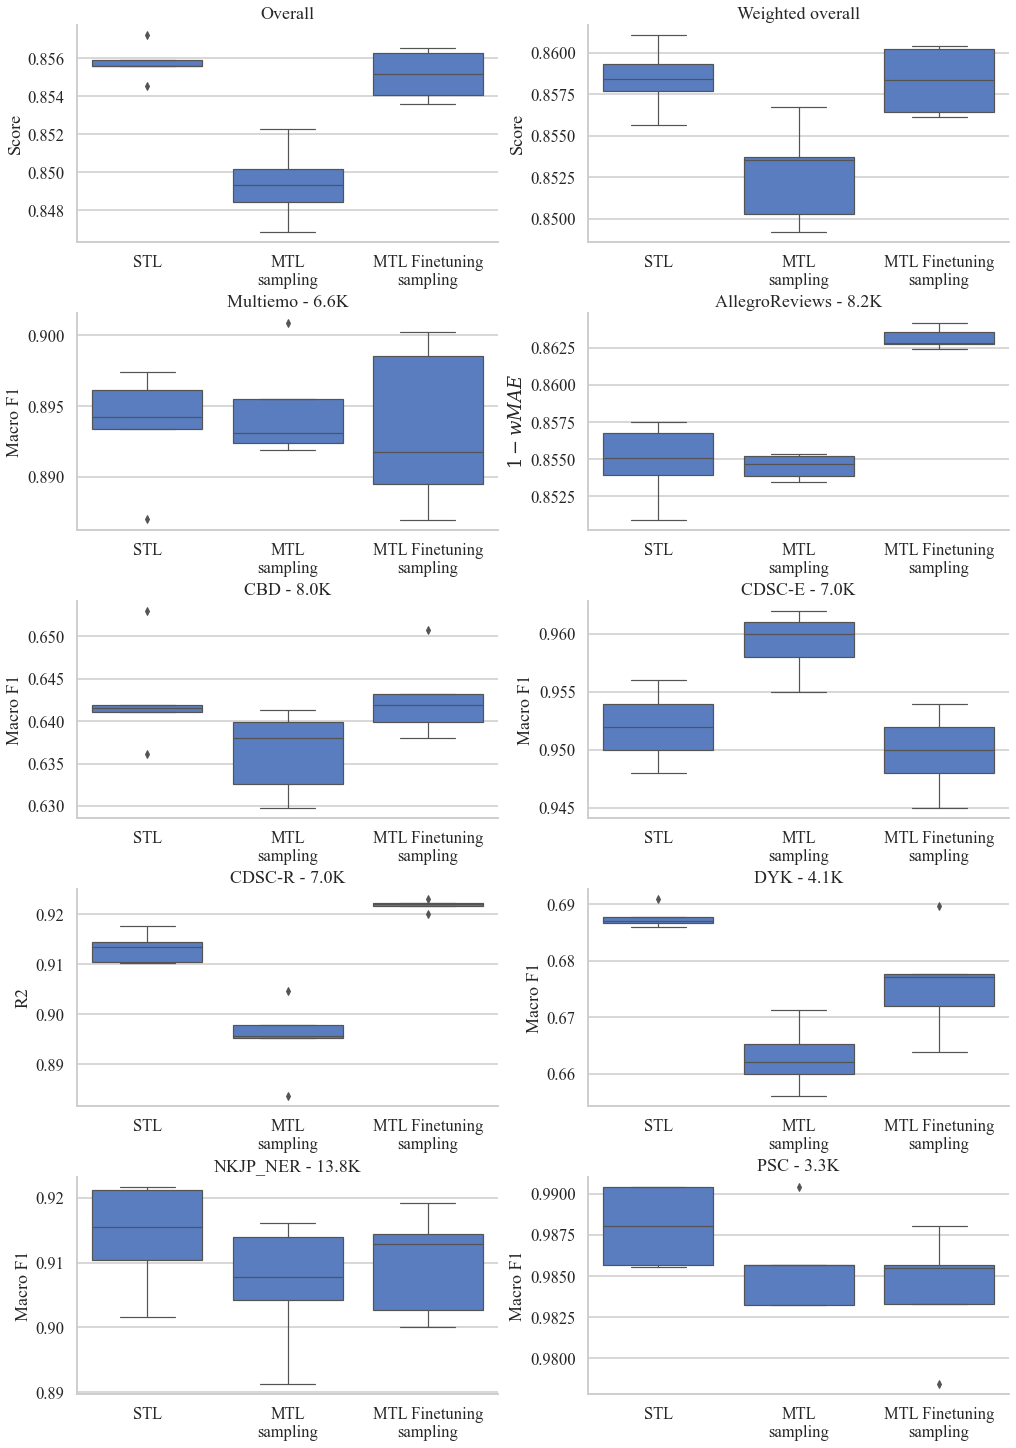

In [17]:
order = ['STL', 'MTL_sampling', 'MTL Finetuning_sampling']

hue_order = ['polish-roberta']

visualize_boxplot(
    df, tasks=tasks,
    cols=2, row_height=4, fig_width=14, all_tasks=True,
    savefig=True, filename='ft_mtl2_polish_roberta_vs_distilroberta_full_results_plot',
    showfliers=True, linewidth=1.2, order=order, 
    hue='model_kind', 
    hue_order=hue_order,
    add_legend=False, ncol=1, loc=None, bbox_to_anchor=None, only_fig_legend=False,
    runtimes=False, steps=False, 
)